# Resnet 101 dropout 0,4

In [6]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

Lokacija dataset-a

In [7]:
dataset_path = "../../data_set"

In [8]:
classes = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]


Inicijalizacija lista za cuvanje podataka


In [9]:
data = []
labels = []

Ucitavanje slika kroz klase


In [10]:
for class_name in classes:
    class_path = os.path.join(dataset_path, "Training", class_name)
    for filename in os.listdir(class_path):
        img_path = os.path.join(class_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Učitavanje slike u crno-belom formatu
        img = cv2.resize(img, (224, 224))  # Da sve slike budu 224x224px
        img = np.stack((img,)*3, axis=-1)  # tri kanala od grayscale slike (resnet-u treba 3 kanala)
        data.append(img)
        labels.append(classes.index(class_name))

Konvertovanje listi u numpy


In [11]:
data = np.array(data) / 255.0  # Normalizacija vrednosti piksela

labels = np.array(labels)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)


ImageDataGenerator za data augmentation


In [13]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

ResNet-50 model

In [14]:
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[-4:]:
    layer.trainable = True

Dodavanje prilagođenih slojeva

In [15]:
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)

x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.4)(x)
outputs = Dense(len(classes), activation='softmax')(x)


In [16]:
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Cuvanje tezina

In [17]:

checkpoint_path = "model.weights.h5" 
checkpoint = ModelCheckpoint(checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_loss', mode='min')

Treniranje modela

In [13]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=4), epochs=20, validation_data=(X_val, y_val), callbacks=[checkpoint])


Epoch 1/20


/home/teki/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


574/574 ━━━━━━━━━━━━━━━━━━━━ 1236s 2s/step - accuracy: 0.2961 - loss: 5.3944 - val_accuracy: 0.2718 - val_loss: 2.3336
Epoch 2/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 1236s 2s/step - accuracy: 0.2780 - loss: 2.1047 - val_accuracy: 0.2927 - val_loss: 1.8260
Epoch 3/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 1236s 2s/step - accuracy: 0.2968 - loss: 1.6192 - val_accuracy: 0.3693 - val_loss: 2.4170
Epoch 4/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 1236s 2s/step - accuracy: 0.2916 - loss: 1.4650 - val_accuracy: 0.3850 - val_loss: 4.0209
Epoch 5/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 1239s 2s/step - accuracy: 0.3325 - loss: 1.3554 - val_accuracy: 0.3885 - val_loss: 1.6587
Epoch 6/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 1248s 2s/step - accuracy: 0.3663 - loss: 1.2793 - val_accuracy: 0.4843 - val_loss: 1.3428
Epoch 7/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 1246s 2s/step - accuracy: 0.3974 - loss: 1.2702 - val_accuracy: 0.4443 - val_loss: 1.7561
Epoch 8/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 1234s 2s/step - accuracy: 0.3732 - loss: 1.2668 - val_accurac

In [18]:
model.load_weights(checkpoint_path)

/home/teki/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 850 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Evaluacija modela na test skupu


In [19]:
test_data = []
test_labels = []

In [20]:
for class_name in classes:
    class_path = os.path.join(dataset_path, "Testing", class_name)
    for filename in os.listdir(class_path):
        img_path = os.path.join(class_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (224, 224))
        img = np.stack((img,)*3, axis=-1)
        test_data.append(img)
        test_labels.append(classes.index(class_name))

In [21]:
test_data = np.array(test_data) / 255.0
test_labels = np.array(test_labels)

Classification report

In [22]:
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)
report = classification_report(test_labels, predicted_classes, target_names=classes)
print("Classification report:")
print(report)

13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step
Classification report:
                  precision    recall  f1-score   support

    glioma_tumor       0.29      0.10      0.15       100
meningioma_tumor       0.35      0.94      0.51       115
        no_tumor       0.00      0.00      0.00       105
 pituitary_tumor       0.32      0.22      0.26        74

        accuracy                           0.34       394
       macro avg       0.24      0.31      0.23       394
    weighted avg       0.24      0.34      0.23       394



/home/teki/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/teki/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/teki/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Preciznost je vrlo niska za sve klase, što znači da model često daje pogrešne pozitivne predikcije.

Odziv je umeren za meningioma tumore, ali vrlo nizak za glioma tumore, slike bez tumora, i pituitary tumore, što znači da model propušta veliki broj stvarnih slučajeva ovih tumora.

F1-score vrednosti pokazuju da model ima veoma slabe performanse za sve klase, sa nešto boljim performansama za meningioma tumore, ali i dalje nedovoljnim.

Ukupna tačnost modela je 34%, što je vrlo nisko, i postoji prostor za značajno poboljšanje u detekciji svih vrsta tumora.

Čuvanje rezultata


In [23]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)


2024-06-18 12:06:07.753833: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1382449152 exceeds 10% of free system memory.


In [24]:
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)


In [25]:
test_loss, test_accuracy = model.evaluate(test_data, test_labels, verbose=0)

In [26]:
results = {
    "Model": ["ResNet101"],
    "Train Loss": [train_loss],
    "Train Accuracy": [train_accuracy],
    "Validation Loss": [val_loss],
    "Validation Accuracy": [val_accuracy],
    "Test Loss": [test_loss],
    "Test Accuracy": [test_accuracy]
}

In [27]:
results_df = pd.DataFrame(results)
results_df.to_csv("model_results_resnet101.csv", index=False)
print(results_df)

       Model  Train Loss  Train Accuracy  Validation Loss  \
0  ResNet101    1.196028        0.434233         1.187894   

   Validation Accuracy  Test Loss  Test Accuracy  
0             0.426829   1.819371       0.340102  


Graficki prikaz rezultata

In [29]:
history = {
    'accuracy': [0.2961, 0.2780, 0.2968, 0.2916, 0.3325, 0.3663, 0.3974, 0.3732, 0.3737, 0.3949, 
                 0.4272, 0.4151, 0.4026, 0.4068, 0.3934, 0.3887, 0.4080, 0.4226, 0.4146, 0.4017],
    'val_accuracy': [0.2718, 0.2927, 0.3693, 0.3850, 0.3885, 0.4843, 0.4443, 0.3328, 0.3972, 0.4129, 
                     0.3310, 0.3519, 0.4582, 0.4408, 0.4024, 0.4686, 0.4547, 0.4268, 0.4268, 0.4216],
    'loss': [5.3944, 2.1047, 1.6192, 1.4650, 1.3554, 1.2793, 1.2702, 1.2668, 1.2771, 1.2736, 
             1.2334, 1.2460, 1.2400, 1.2602, 1.2927, 1.2578, 1.2465, 1.2300, 1.2511, 1.2468],
    'val_loss': [2.3336, 1.8260, 2.4170, 4.0209, 1.6587, 1.3428, 1.7561, 1.4721, 1.2083, 1.2254, 
                 11.0322, 1.2550, 1.2212, 1.2057, 5.7910, 1.2611, 1.2225, 1.1879, 1.3011, 1.2188]
} # rucno ubaceno jer je krenel pukao posle treniranja


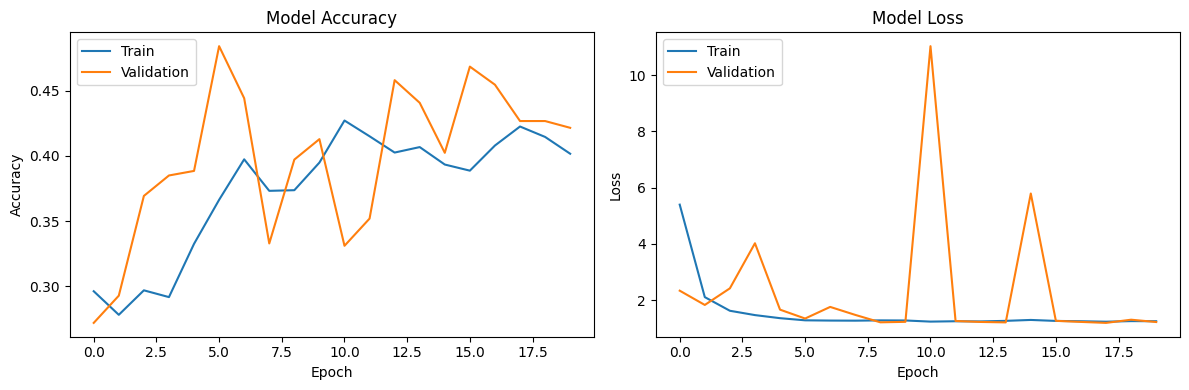

In [31]:
# train history
plt.figure(figsize=(12, 4))

# Plot training, validation
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training, validation
plt.subplot(1, 2, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

**Accuracy**

Tacnost na trening skupu raste do oko 0.45, što pokazuje da model uči na trening podacima. Tacnost na validacionom skupu osciluje između 0.3 i 0.45, ali pokazuje trend ka boljem. Ove oscilacije ukazuju na nestabilnu generalizaciju, što može biti rezultat preprilagodjavanja


**Loss**

Greska na trening setu opada ispod 2, što pokazuje da model smanjuje grešku na trening podacima. Greska na validacionom skupu osciluje, sa vrednostima koje se kreću između 1 i 10. Ova varijabilnost u validacionoj grešci ukazuje na to da model ima poteškoća u učenju stabilnih karakteristika iz validacionih podataka. Takve oscilacije mogu biti znak preprilagodjavanja, gde model dobro radi na trening podacima, ali ne uspeva da generalizuje na validacioni skup.